In [9]:
import os
import re
import platform
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import toad
from sklearn.metrics import roc_auc_score

from tensorflow import keras
from tensorflow.python.keras.metrics import AUC
from tensorflow.python.keras.models import load_model
from tensorflow.keras.metrics import Mean

from deepctr.layers import custom_objects
from deepctr.layers.utils import NoMask
from deepctr.models.multitask_modified.mmoe import MMOELayer
from deepctr.models.multitask_modified.multitaskbase import MultiTaskModelBase
from deepctr.metrics import calc_lift3, cal_ks

custom_objects['NoMask'] = NoMask
custom_objects['MMOELayer'] = MMOELayer
custom_objects['MultiTaskModelBase'] = MultiTaskModelBase
custom_objects['Mean'] = Mean
custom_objects['AUC'] = AUC

In [2]:
def map_score(x):
    if isinstance(x, float):
        return np.nan
    if x == 'DFLT_VAL' or x == '-2' or x =='库无记录':
        return np.nan
    if x == '0':
        return '0'
    temp = x.split(',')[0][1:]
    if temp == '0':
        return '1'
    elif temp == '-999':
        return '0'
    else:
        return temp

In [3]:
project_name = 'preloan_istrans_overdue2'
run_name = 'uncertainty_weight_fpd4_mask_mob3_k11_mask4'
mode = 'test'
if platform.system() == 'Windows':
    joint_symbol = '\\'
else:
    joint_symbol = '/'
checkpoint_dir = joint_symbol.join([project_name, 'ckt', run_name])
tensorboard_dir = joint_symbol.join([project_name, 'log_dir', run_name])
summary_dir = joint_symbol.join([project_name, 'metrics', run_name])
trend_dir = joint_symbol.join([project_name, 'trend', run_name])
if not os.path.exists(trend_dir):
    os.makedirs(trend_dir)
tasks = {'istrans': 'binary', 'fpd4': 'binary', 'mob3_k11': 'binary'}
loss_fns = {'istrans': keras.losses.binary_crossentropy,
            'fpd4': keras.losses.binary_crossentropy,
            'mob3_k11': keras.losses.binary_crossentropy}
metrics_logger = {'istrans': AUC,
                  'fpd4': AUC,
                  'mob3_k11': AUC}
loss_weights = {'istrans': 1, 'fpd4': 6, 'mob3_k11': 6}
if run_name.find('uncertainty') >= 0:
    uncertainty = True
else:
    uncertainty = False
if run_name.find('gradnorm') >= 0:
    gradnorm = True
else:
    gradnorm = False
if run_name.find('bias') >= 0:
    add_bias = True
else:
    add_bias = False
batch_size = 256

In [4]:
data = pd.read_csv('../data/test3.csv')
col_x = ['tz_m12_platform_infos_max_all_overdue_repay_plat_cnt_2',
         'cs_hc_phone_score',
         'upa_max_consume_amt_6m',
         'ab_local_ratio',
         'ab_mobile_cnt',
         'td_i_length_first_all_consumerfinance_365d',
         'yysc_mobile_in_net_period',
         'cs_hnsk_xef',
         'duotou_br_als_m3_id_pdl_allnum',
         'operation_sys',
         'credit_repayment_score_bj_2',
         'tz_evesums_m24_verif_sum',
         'hds_mobile_reli_rank',
         'selffill_is_have_creditcard',
         'bwjk_xyf',
         'duotou_bes_m1_overdue_money',
         'credit_score_ronghuixf',
         'duotou_br_als_m12_id_pdl_allnum',
         'td_zhixin_score',
         'duotou_br_als_m12_id_caon_allnum',
         'ab_prov_cnt',
         'dxm_dt_score',
         'td_3m_idcard_lending_cnt',
         'td_xyf_dq_i_ratio_cnt_grp_max_partner_loan_all',
         'immediate_relation_cnt',
         'bj_jc_m36_consume_cnt',
         'duotou_br_als_m3_id_nbank_allnum',
         'study_app_cnt',
         'selffill_marital_status',
         'tx_m6_cell_allnum',
         'cs_mf_score_dt',
         'cust_work_city',
         'ali_rain_score',
         'selffill_degree',
         'pre_loan_flag',
         'cust_gender',
         'upa_failed_deal_cnt_6m',
         'td_i_cnt_partner_all_imbank_365d',
         'td_xyf_dq_score',
         'duotou_br_alf_apirisk_all_sum',
         'hds_36m_month_max_purchase_money_excp_doub11_12',
         'credit_score_sh',
         'wy_credit_score_credit_apply',
         'duotou_br_als_m12_cell_nbank_allnum',
         'tx_m12_id_platnum',
         'umeng_score',
         'relation_contact_cnt',
         'br_frg_list_level',
         'mg_callb_contacts_number_statistic_cnt_to_applied',
         'area_risk_level',
         'duotou_bes_m3_repay_times',
         'ab_local_cnt']
bias_features = {'istrans': ['pre_loan_flag']}
bias_dropout_dict = {'istrans': 0.1, 'fpd4': 0.1}

data['fpd4_weight'] = 1.0
data['fpd4_mask'] = 1.0
if run_name.find('fpd4_nomask') >= 0:
    pass
else:
    data.loc[(data['if_t4'] != 1), 'fpd4_weight'] = 0.0
data.loc[(data['if_t4'] != 1), 'fpd4_mask'] = 0

data['mob3_k11_weight'] = 1.0
data['mob3_k11_mask'] = 1.0
if run_name.find('mob3_k11_nomask') >= 0:
    pass
else:
    data.loc[(data['if_mob3_t11'] != 1), 'mob3_k11_weight'] = 0.0
data.loc[(data['if_mob3_t11'] != 1), 'mob3_k11_mask'] = 0

data['istrans_weight'] = 1.0
data['istrans_mask'] = 1.0
data.loc[data['pre_loan_flag'] != 0, 'istrans_mask'] = 0.0
if run_name.find('istrans_mask') >= 0:
    data.loc[data['pre_loan_flag'] != 0, 'istrans_weight'] = 0.0

data['fpd4'] = data['fpd4'].fillna(0)
data['mob3_k11'] = data['mob3_k11'].fillna(0)
data.loc[data['fpd4'] == -1, 'fpd4'] = 0
data.loc[data['mob3_k11'] == -1, 'mob3_k11'] = 0

data[col_x] = data[col_x].replace([-99, -1, np.nan, '-1', '-99', '-1111', '-999', -999], np.nan)

data['wy_credit_score_credit_apply'] = data['wy_credit_score_credit_apply'].astype(float)
data['upa_failed_deal_cnt_6m'] = data['upa_failed_deal_cnt_6m'].astype(float)
data['upa_max_consume_amt_6m'] = data['upa_max_consume_amt_6m'].astype(float)
data['cust_gender'] = data['cust_gender'].map({'男': 0.0, '女': 1.0})
data['umeng_score'] = data['umeng_score'].replace([-98], np.nan)
data['td_xyf_dq_i_ratio_cnt_grp_max_partner_loan_all'] = data['td_xyf_dq_i_ratio_cnt_grp_max_partner_loan_all'].map(
    map_score).astype(float)
data['yysc_mobile_in_net_period'] = data['yysc_mobile_in_net_period'].map(map_score).astype(float)
data['selffill_is_have_creditcard'] = data['selffill_is_have_creditcard'].map({'N': 0.0, 'Y': 1.0, '0': np.nan})
data['operation_sys'] = data['operation_sys'].replace(
    {'IOS': 'ios', 'iPhone OS': 'ios', 'iOS': 'ios', 'Android': 'android'})
data['operation_sys'] = data['operation_sys'].map({'ios': 0.0, 'android': 1.0})
data['ab_prov_cnt'] = data['ab_prov_cnt'].astype(float)
data['hds_mobile_reli_rank'] = data['hds_mobile_reli_rank'].map({'M0': np.nan, 'Ma': 0.0, 'Mb': 1.0})
data['td_i_cnt_partner_all_imbank_365d'] = data['td_i_cnt_partner_all_imbank_365d'].map(map_score).astype(float)
data['td_i_length_first_all_consumerfinance_365d'] = data['td_i_length_first_all_consumerfinance_365d'].map(
    map_score).astype(float)
data['tx_m6_cell_allnum'] = data['tx_m6_cell_allnum'].astype(float)

with open('../data/fill_na_dict.json', 'r') as f:
    fill_na_dict = json.load(f)
data[col_x] = data[col_x].fillna(fill_na_dict)

import pickle
with open('../data/mms4.pkl', 'rb') as f:
    mms = pickle.load(f)
data[col_x] = mms.transform(data[col_x])

feature_names = col_x

D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.24.2 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [5]:
best_metric = -1
best_model = None
for i in os.listdir(checkpoint_dir):
    if i.find('best_model') >= 0:
        metric = float(re.match('.*AUC(.*).h5', i)[1])
        if metric > best_metric:
            best_metric = metric
            best_model = i
print('loading ', joint_symbol.join([checkpoint_dir, best_model]))
model = load_model(joint_symbol.join([checkpoint_dir, best_model]), custom_objects=custom_objects)

loading  preloan_istrans_overdue2\ckt\uncertainty_weight_fpd4_mask_mob3_k11_mask4\best_model_epoch7_val_fpd4_AUC0.7122.h5


DeepCTR version 0.9.0 detected. Your version is 0.8.7.
Use `pip install -U deepctr` to upgrade.Changelog: https://github.com/shenweichen/DeepCTR/releases/tag/v0.9.0


In [19]:
task_name = 'istrans'
df = data[(data['set'] == '1train')]
predictions =  model.predict({name: df[name] for name in feature_names})
df['pred_{}'.format(task_name)] = predictions[task_name][:, 0]
selected_psi = ['pred_{}'.format(task_name)]
target = task_name
combiner = toad.transform.Combiner()
combiner.fit(df[selected_psi + [task_name]],
             y=task_name,
             n_bins=20,
             method='quantile',
             empty_separate=True)

D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-----
1train (18836, 98)
-----
2test (9418, 98)
-----
3oot (9105, 98)
-----
4oot (4253, 98)
-----
5oot (5459, 98)
-----
6oot (5540, 98)
-----
7oot (2900, 98)


D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

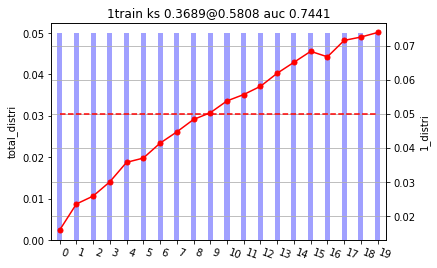

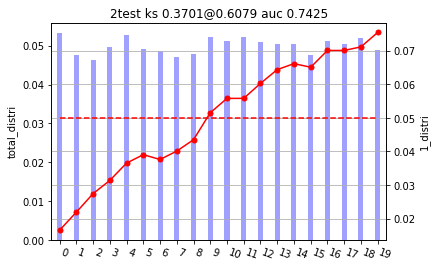

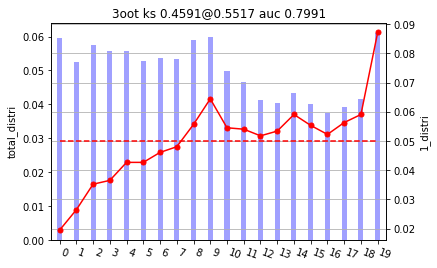

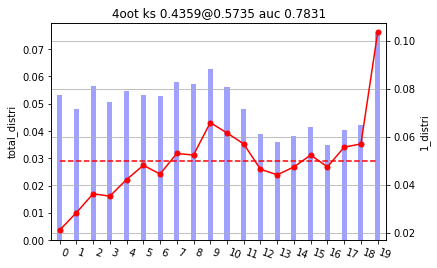

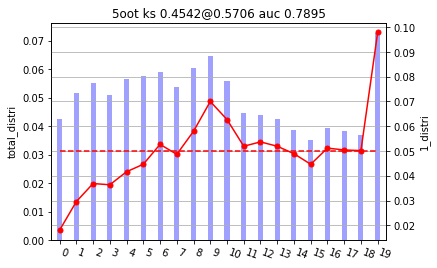

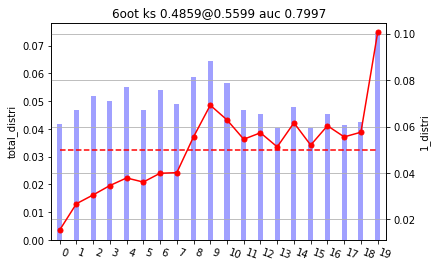

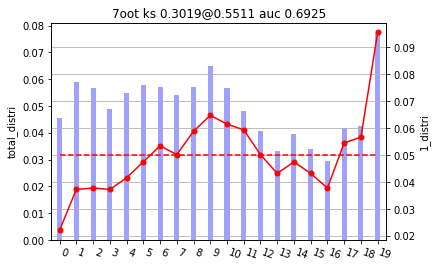

In [20]:
for i in ['1train', '2test', '3oot', '4oot', '5oot', '6oot', '7oot']:
    print('-----')
    df = data.loc[(data['set']==i)]
    print(i, df.shape)
    df['pred_{}'.format(task_name)] = model.predict({name: df[name] for name in feature_names})[task_name][:, 0]
    ks = cal_ks(df['pred_{}'.format(task_name)].values, df[task_name].values)
    auc = roc_auc_score(df[task_name].values, df['pred_{}'.format(task_name)].values)
    plt.close('all')
    df['range_{}'.format(task_name)] = combiner.transform(df['pred_{}'.format(task_name)])
    table, ax = calc_lift3(df, 'range_{}'.format(task_name), task_name,
                           range_col='range_{}'.format(task_name),
                           title_name=i+' ks {:.4f}@{:.4f} auc {:.4f}'.format(ks[0], ks[1], auc))
    plt.show()

D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


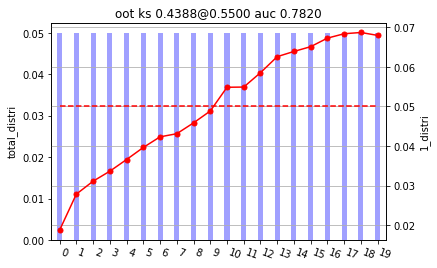

In [34]:
df = data[(data['set'] == '3oot') |
          (data['set'] == '4oot') |
          (data['set'] == '5oot') |
          (data['set'] == '6oot') |
          (data['set'] == '7oot')]
predictions =  model.predict({name: df[name] for name in feature_names})
df['pred_{}'.format(task_name)] = predictions[task_name][:, 0]
selected_psi = ['pred_{}'.format(task_name)]
target = task_name
combiner = toad.transform.Combiner()
combiner.fit(df[selected_psi + [task_name]],
             y=task_name,
             n_bins=20,
             method='quantile',
             empty_separate=True)
ks = cal_ks(df['pred_{}'.format(task_name)].values, df[task_name].values)
auc = roc_auc_score(df[task_name].values, df['pred_{}'.format(task_name)].values)
df['range_{}'.format(task_name)] = combiner.transform(df['pred_{}'.format(task_name)])
plt.close('all')
table, ax = calc_lift3(df, 'range_{}'.format(task_name), task_name,
                       range_col='range_{}'.format(task_name),
                       title_name='oot ks {:.4f}@{:.4f} auc {:.4f}'.format(ks[0], ks[1], auc))
plt.show()

In [36]:
table

,range,good,bad,count,good_distri,bad_distri,total_distri,cumgood_distri,cumbad_distri,badrate,cumbadrate,lift,ks
0,0,1007,356,1363,0.121883,0.018742,0.050006,0.121883,0.018742,0.261189,0.261189,0.374794,0.103142
1,1,834,529,1363,0.100944,0.027849,0.050006,0.222827,0.046591,0.388114,0.324652,0.556927,0.176236
2,2,772,591,1363,0.093440,0.031113,0.050006,0.316267,0.077705,0.433602,0.360968,0.622201,0.238563
3,3,724,639,1363,0.087630,0.033640,0.050006,0.403897,0.111345,0.468819,0.387931,0.672735,0.292552
4,4,667,695,1362,0.080731,0.036589,0.049969,0.484628,0.147934,0.510279,0.412386,0.732228,0.336695
5,5,610,753,1363,0.073832,0.039642,0.050006,0.558460,0.187576,0.552458,0.435734,0.792753,0.370885
6,6,559,804,1363,0.067659,0.042327,0.050006,0.626120,0.229903,0.589875,0.457757,0.846445,0.396217
7,7,544,819,1363,0.065844,0.043117,0.050006,0.691963,0.273019,0.600880,0.475649,0.862237,0.418944
8,8,492,871,1363,0.059550,0.045854,0.050006,0.751513,0.318873,0.639032,0.493804,0.916983,0.432640
9,9,434,928,1362,0.052530,0.048855,0.049969,0.804043,0.367728,0.681351,0.512548,0.977709,0.436314


In [35]:
combiner.export()

{'pred_istrans': [0.20879748463630676,
  0.26651251912117,
  0.310285484790802,
  0.3497867345809937,
  0.38555049896240234,
  0.4207543909549713,
  0.45515319108963015,
  0.49500590562820435,
  0.5359268426895142,
  0.5779728293418884,
  0.6158025979995727,
  0.6516685247421266,
  0.6845378994941711,
  0.716870379447937,
  0.7464578747749329,
  0.7761258006095886,
  0.8044546127319336,
  0.8335691809654235,
  0.870772671699524]}

In [39]:
task_name = 'fpd4'
df = data[(data['set'] == '1train')]
df = df[df[task_name + '_mask'] == 1]
predictions =  model.predict({name: df[name] for name in feature_names})
df['pred_{}'.format(task_name)] = predictions[task_name][:, 0]
selected_psi = ['pred_{}'.format(task_name)]
target = task_name
combiner = toad.transform.Combiner()
combiner.fit(df[selected_psi + [task_name]],
             y=task_name,
             n_bins=20,
             method='quantile',
             empty_separate=True)

-----
1train (11215, 98)
-----
2test (5608, 98)
-----
3oot (6163, 98)
-----
4oot (3034, 98)
-----
5oot (3986, 98)
-----
6oot (3959, 98)
-----
7oot (1090, 98)


D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

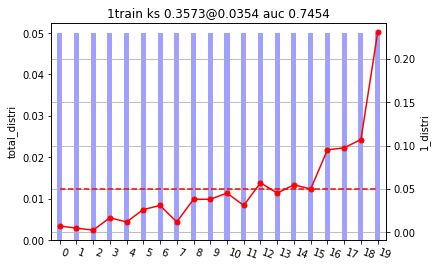

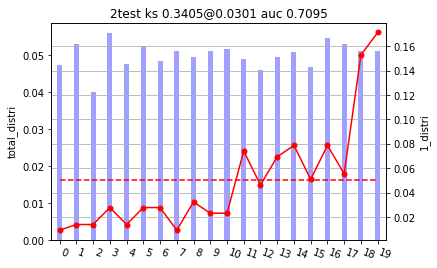

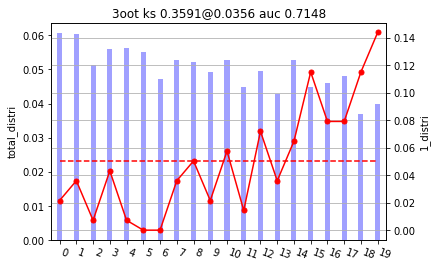

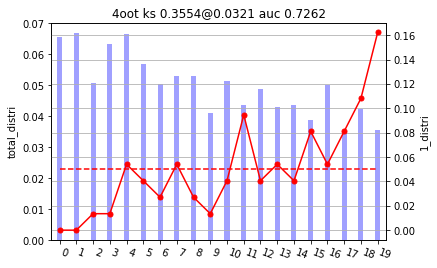

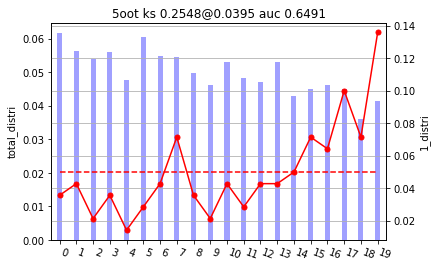

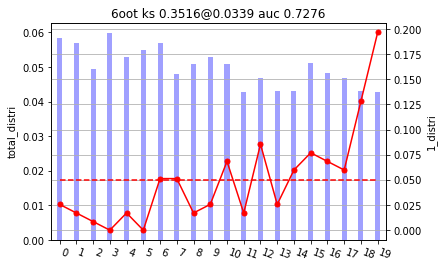

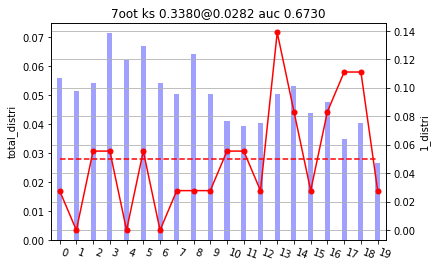

In [40]:
for i in ['1train', '2test', '3oot', '4oot', '5oot', '6oot', '7oot']:
    print('-----')
    df = data.loc[(data['set']==i) & (data[task_name + '_mask'] == 1)]
    print(i, df.shape)
    df['pred_{}'.format(task_name)] = model.predict({name: df[name] for name in feature_names})[task_name][:, 0]
    ks = cal_ks(df['pred_{}'.format(task_name)].values, df[task_name].values)
    auc = roc_auc_score(df[task_name].values, df['pred_{}'.format(task_name)].values)
    plt.close('all')
    df['range_{}'.format(task_name)] = combiner.transform(df['pred_{}'.format(task_name)])
    table, ax = calc_lift3(df, 'range_{}'.format(task_name), task_name,
                           range_col='range_{}'.format(task_name),
                           title_name=i+' ks {:.4f}@{:.4f} auc {:.4f}'.format(ks[0], ks[1], auc))
    plt.show()

D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


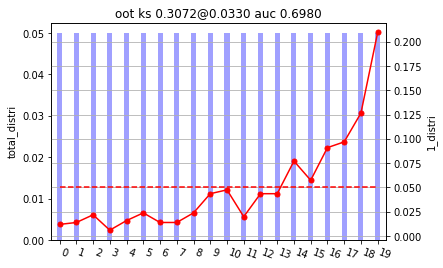

In [46]:
df = data[(data['set'] == '3oot') |
          (data['set'] == '4oot') |
          (data['set'] == '5oot') |
          (data['set'] == '6oot') |
          (data['set'] == '7oot')]
# df = df[df[task_name + '_mask'] == 1]
predictions =  model.predict({name: df[name] for name in feature_names})
df['pred_{}'.format(task_name)] = predictions[task_name][:, 0]
selected_psi = ['pred_{}'.format(task_name)]
target = task_name
combiner = toad.transform.Combiner()
combiner.fit(df[selected_psi + [task_name]],
             y=task_name,
             n_bins=20,
             method='quantile',
             empty_separate=True)
ks = cal_ks(df['pred_{}'.format(task_name)].values,
            df[task_name].values,
            sample_weight=df[task_name + '_mask'].values)
auc = roc_auc_score(df[task_name].values,
                    df['pred_{}'.format(task_name)].values,
                    sample_weight=df[task_name + '_mask'].values)
df['range_{}'.format(task_name)] = combiner.transform(df['pred_{}'.format(task_name)])
plt.close('all')
table, ax = calc_lift3(df, 'range_{}'.format(task_name), task_name,
                       range_col='range_{}'.format(task_name),
                       title_name='oot ks {:.4f}@{:.4f} auc {:.4f}'.format(ks[0], ks[1], auc))
plt.show()

In [47]:
table

,range,good,bad,count,good_distri,bad_distri,total_distri,cumgood_distri,cumbad_distri,badrate,cumbadrate,lift,ks
0,0,1357,6,1363,0.050727,0.011858,0.050006,0.050727,0.011858,0.004402,0.004402,0.237128,0.038869
1,1,1356,7,1363,0.050690,0.013834,0.050006,0.101417,0.025692,0.005136,0.004769,0.276649,0.075725
2,2,1352,11,1363,0.050540,0.021739,0.050006,0.151957,0.047431,0.008070,0.005869,0.434735,0.104526
3,3,1360,3,1363,0.050839,0.005929,0.050006,0.202796,0.053360,0.002201,0.004952,0.118564,0.149436
4,4,1354,8,1362,0.050615,0.015810,0.049969,0.253411,0.069170,0.005874,0.005136,0.316403,0.184241
5,5,1351,12,1363,0.050503,0.023715,0.050006,0.303914,0.092885,0.008804,0.005748,0.474256,0.211028
6,6,1356,7,1363,0.050690,0.013834,0.050006,0.354604,0.106719,0.005136,0.005660,0.276649,0.247884
7,7,1356,7,1363,0.050690,0.013834,0.050006,0.405293,0.120553,0.005136,0.005595,0.276649,0.284740
8,8,1351,12,1363,0.050503,0.023715,0.050006,0.455796,0.144269,0.008804,0.005951,0.474256,0.311527
9,9,1340,22,1362,0.050092,0.043478,0.049969,0.505888,0.187747,0.016153,0.006971,0.870108,0.318141


In [48]:
combiner.export()


{'pred_fpd4': [0.0034055709838867188,
  0.0050106048583984375,
  0.006544566154479981,
  0.008058375120162964,
  0.00970393419265747,
  0.011407250165939332,
  0.013220286369323733,
  0.015185058116912845,
  0.017346161603927615,
  0.019691675901412964,
  0.022435057163238525,
  0.025522667169570926,
  0.028922247886657718,
  0.03300513029098511,
  0.037711381912231445,
  0.043804806470870976,
  0.051439785957336434,
  0.06219841241836551,
  0.08179048895835882]}

In [49]:
task_name = 'mob3_k11'
df = data[(data['set'] == '1train')]
df = df[df[task_name + '_mask'] == 1]
predictions =  model.predict({name: df[name] for name in feature_names})
df['pred_{}'.format(task_name)] = predictions[task_name][:, 0]
selected_psi = ['pred_{}'.format(task_name)]
target = task_name
combiner = toad.transform.Combiner()
combiner.fit(df[selected_psi + [task_name]],
             y=task_name,
             n_bins=20,
             method='quantile',
             empty_separate=True)

-----
1train (11215, 98)
-----
2test (5608, 98)
-----
3oot (6163, 98)
-----
4oot (3034, 98)


D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

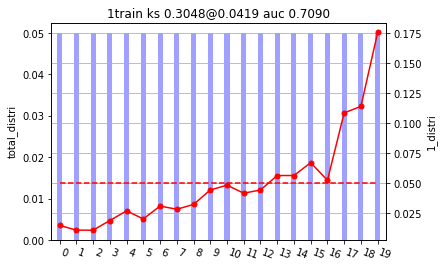

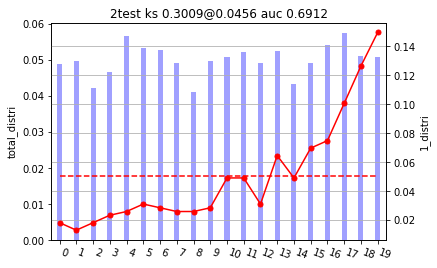

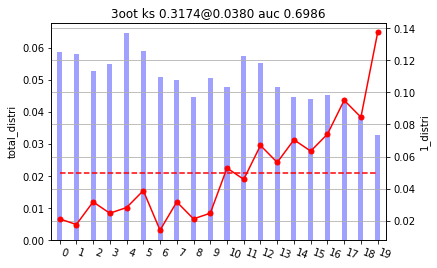

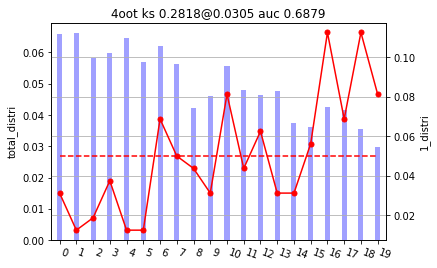

In [51]:
for i in ['1train', '2test', '3oot', '4oot']:
    print('-----')
    df = data.loc[(data['set']==i) & (data[task_name + '_mask'] == 1)]
    print(i, df.shape)
    df['pred_{}'.format(task_name)] = model.predict({name: df[name] for name in feature_names})[task_name][:, 0]
    ks = cal_ks(df['pred_{}'.format(task_name)].values, df[task_name].values)
    auc = roc_auc_score(df[task_name].values, df['pred_{}'.format(task_name)].values)
    plt.close('all')
    df['range_{}'.format(task_name)] = combiner.transform(df['pred_{}'.format(task_name)])
    table, ax = calc_lift3(df, 'range_{}'.format(task_name), task_name,
                           range_col='range_{}'.format(task_name),
                           title_name=i+' ks {:.4f}@{:.4f} auc {:.4f}'.format(ks[0], ks[1], auc))
    plt.show()

D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


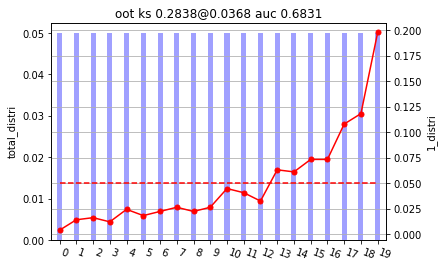

In [57]:
df = data[(data['set'] == '3oot') |
          (data['set'] == '4oot') |
          (data['set'] == '5oot') |
          (data['set'] == '6oot') |
          (data['set'] == '7oot')]
# df = df[df[task_name + '_mask'] == 1]
predictions =  model.predict({name: df[name] for name in feature_names})
df['pred_{}'.format(task_name)] = predictions[task_name][:, 0]
selected_psi = ['pred_{}'.format(task_name)]
target = task_name
combiner = toad.transform.Combiner()
combiner.fit(df[selected_psi],
             y=None,
             n_bins=20,
             method='quantile',
             empty_separate=True)
ks = cal_ks(df['pred_{}'.format(task_name)].values,
            df[task_name].values,
            sample_weight=df[task_name + '_mask'].values)
auc = roc_auc_score(df[task_name].values,
                    df['pred_{}'.format(task_name)].values,
                    sample_weight=df[task_name + '_mask'].values)
df['range_{}'.format(task_name)] = combiner.transform(df['pred_{}'.format(task_name)])
plt.close('all')
table, ax = calc_lift3(df, 'range_{}'.format(task_name), task_name,
                       range_col='range_{}'.format(task_name),
                       title_name='oot ks {:.4f}@{:.4f} auc {:.4f}'.format(ks[0], ks[1], auc))
plt.show()

In [58]:
table

,range,good,bad,count,good_distri,bad_distri,total_distri,cumgood_distri,cumbad_distri,badrate,cumbadrate,lift,ks
0,0,1361.0,2.0,1363.0,0.050848,0.004073,0.050006,0.050848,0.004073,0.001467,0.001467,0.081457,0.046775
1,1,1356.0,7.0,1363.0,0.050661,0.014257,0.050006,0.101509,0.018330,0.005136,0.003302,0.285101,0.083179
2,2,1355.0,8.0,1363.0,0.050624,0.016293,0.050006,0.152133,0.034623,0.005869,0.004157,0.325830,0.117510
3,3,1357.0,6.0,1363.0,0.050699,0.012220,0.050006,0.202832,0.046843,0.004402,0.004219,0.244372,0.155989
4,4,1350.0,12.0,1362.0,0.050437,0.024440,0.049969,0.253269,0.071283,0.008811,0.005136,0.489103,0.181986
5,5,1354.0,9.0,1363.0,0.050587,0.018330,0.050006,0.303856,0.089613,0.006603,0.005381,0.366558,0.214243
6,6,1352.0,11.0,1363.0,0.050512,0.022403,0.050006,0.354367,0.112016,0.008070,0.005765,0.448016,0.242351
7,7,1350.0,13.0,1363.0,0.050437,0.026477,0.050006,0.404805,0.138493,0.009538,0.006237,0.529473,0.266312
8,8,1352.0,11.0,1363.0,0.050512,0.022403,0.050006,0.455316,0.160896,0.008070,0.006441,0.448016,0.294420
9,9,1349.0,13.0,1362.0,0.050400,0.026477,0.049969,0.505716,0.187373,0.009545,0.006751,0.529862,0.318343


In [59]:
combiner.export()

{'pred_mob3_k11': [0.0035453736782073975,
  0.005126386880874634,
  0.006673359870910645,
  0.008284467458724977,
  0.00992518663406372,
  0.011709493398666383,
  0.013618522882461548,
  0.01560145616531372,
  0.01777361631393433,
  0.02029910683631897,
  0.023192697763442995,
  0.026719194650650025,
  0.03061609268188477,
  0.0352527678012848,
  0.04080706834793091,
  0.04749390482902527,
  0.05600690841674806,
  0.06680976152420044,
  0.08510236740112305]}